Lección 3. Modelos lineales
===========================

**Author:** Marcos Bujosa



<div class="abstract" id="org0c933bf">
<p>
Analizaremos las dificultades que plantea la <b>correlación serial</b> y veremos cómo la estacionariedad en sentido débil los simplifica. Nos centraremos en los <b>procesos lineales</b>, estudiando su valor esperado, su función de autocovarianza, las covarianzas cruzadas entre ellos.
</p>

</div>

-   ([slides](https://mbujosab.github.io/Econometria-Aplicada/Transparencias/Lecc03.slides.html)) &mdash; ([html](https://mbujosab.github.io/Econometria-Aplicada/Lecciones-html/Lecc03.html)) &mdash; ([pdf](https://mbujosab.github.io/Econometria-Aplicada/Lecciones-pdf/Lecc03.pdf)) &mdash; ([mybinder](https://mybinder.org/v2/gh/mbujosab/Econometria-Aplicada/gh-pages?labpath=CuadernosElectronicos/Lecc03.ipynb))



#### Carga de algunos módulos de python y creación de directorios auxiliares



In [1]:
# Para trabajar con los datos y dibujarlos necesitamos cargar algunos módulos de python
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib as mpl
# definimos parámetros para mejorar los gráficos
mpl.rc('text', usetex=False)
import matplotlib.pyplot as plt   # data visualization

##### Creación del directorio auxiliar para albergar las figuras de la lección



Para publicar la lección como pdf o página web, necesito los gráficos como ficheros `.png` alojados algún directorio específico:



In [2]:
imagenes_leccion = "./img/lecc03" # directorio para las imágenes de la lección
import os
os.makedirs(imagenes_leccion, exist_ok=True) # crea el directorio si no existe

Con el siguiente código mejoro los gráficos y logro transformar las tablas con formato $\LaTeX{}$ en ficheros png.



In [3]:
# definimos parámetros para mejorar los gráficos
mpl.rc('text', usetex=True)
mpl.rc('text.latex', preamble=r'\usepackage{amsmath}')

# transformaré salidas en \LaTeX{} de statsmodels a ficheros png que incluiré en las transparencias
import dataframe_image as dfi
from sympy.printing.preview import preview
def repr_png(tex, ImgFile):
    preamble = "\\documentclass[preview]{standalone}\n" \
        "\\usepackage{booktabs,amsmath,amsfonts}\\begin{document}"    
    preview(tex, filename=ImgFile, viewer='file', preamble=preamble, dvioptions=['-D','250'])

## Series temporales vs datos de sección cruzada



Corresponden a observaciones de un mismo objeto a lo largo del
tiempo. El índice indica el instante de cada medición. *El orden
cronológico puede ser crucial* al modelar los datos.

-   El motivo es que frecuentemente el valor medido en un instante de
    tiempo está relacionado con otras mediciones próximas en el tiempo
    (*correlación serial*).

-   Si es así, ya no deberíamos asumir que las variables aleatorias del
    proceso estocástico subyacente, $\boldsymbol{X}=(X_t\mid
      t\in\mathbb{Z})$, son independientes entre sí.

Esto tiene importantes implicaciones en las técnicas de análisis y
los modelos a utilizar.

Veamos algunos ejemplos de series temporales&hellip;



In [4]:
path = '../datos/'
df1 = pd.read_csv(path+'PoblacionAustralia.csv')
df2 = pd.read_csv(path+'PIB_UEM.csv')
df3 = pd.read_csv(path+'Retiro.txt')
df4 = pd.read_csv(path+'IBEX35.csv')
df5 = pd.read_csv(path+'ProduccionCemento.csv')

##### Población en Australia



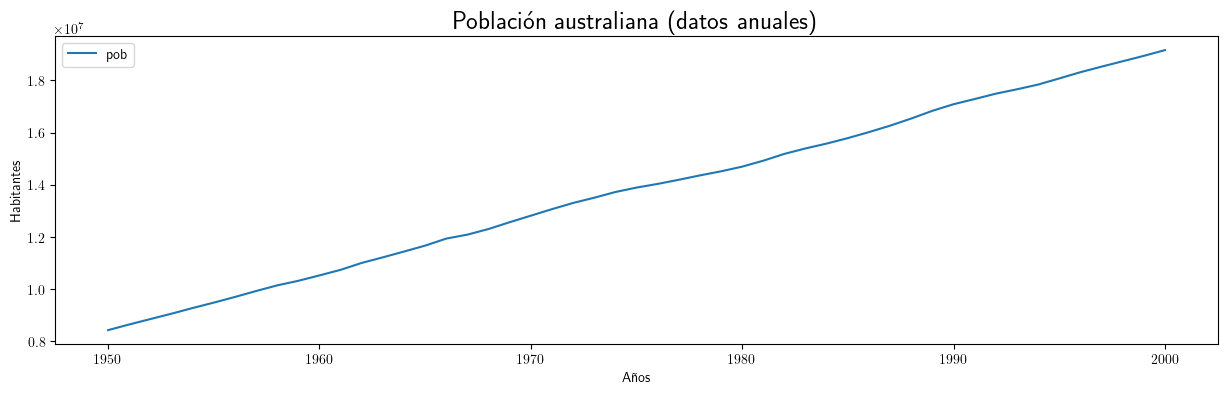

In [5]:
df1.plot(x='obs',xlabel='Años',ylabel='Habitantes',figsize=(15,4)).set_title('Población australiana (datos anuales)',fontsize=18)
plt.savefig('./img/lecc03/PoblacionAustralia.png', dpi=300, bbox_inches='tight')

![img](./img/lecc03/PoblacionAustralia.png)



##### PIB UEM



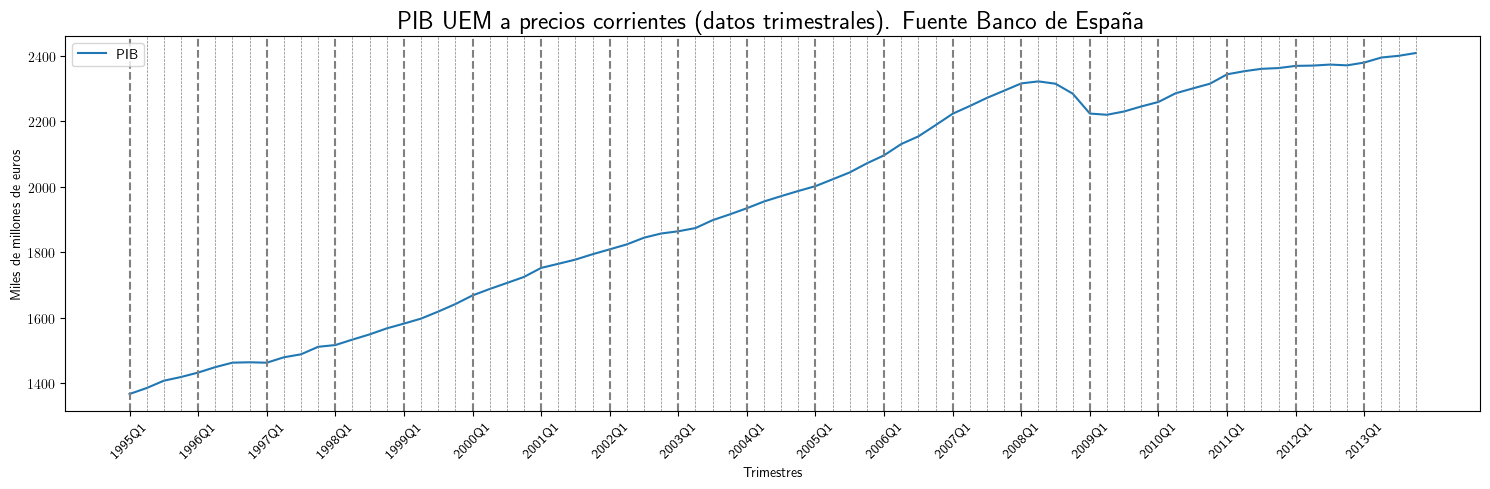

In [6]:
# Crear el gráfico
fig, ax = plt.subplots(figsize=(15, 5))
df2.plot(x='obs', xlabel='Trimestres', ylabel='Miles de millones de euros', ax=ax)
ax.set_title('PIB UEM a precios corrientes (datos trimestrales). Fuente Banco de España', fontsize=18)

# Agregar líneas verticales con diferente grosor
for i, obs in enumerate(df2['obs']):
    if obs.endswith('Q1'):  # Primer trimestre
        ax.axvline(x=i, color='gray', linestyle='--', linewidth=1.5)  # Más gruesa
    else:  # Otros trimestres
        ax.axvline(x=i, color='gray', linestyle='--', linewidth=0.5)  # Más fina

# Personalizar las etiquetas del eje X
ticks = []
labels = []
for i, obs in enumerate(df2['obs']):
    if obs.endswith('Q1'):  # Etiquetas solo en los primeros trimestres
        ticks.append(i)  # Usar el índice como posición
        labels.append(obs)

ax.set_xticks(ticks)  # Configurar las posiciones de las etiquetas
ax.set_xticklabels(labels, rotation=45)  # Configurar las etiquetas correspondientes

# Asegurar que todas las líneas y etiquetas se muestren
plt.tight_layout()
plt.savefig('./img/lecc03/PIB_UEM.png', dpi=300, bbox_inches='tight')

![img](./img/lecc03/PIB_UEM.png)



##### Temperatura media en el Parque del Retiro. Madrid



/tmp/ipykernel_10856/1625092573.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df3['Fecha'] = pd.date_range(start='1985-01', periods=len(df3), freq='M') # cambiar por 'ME' en el futuro


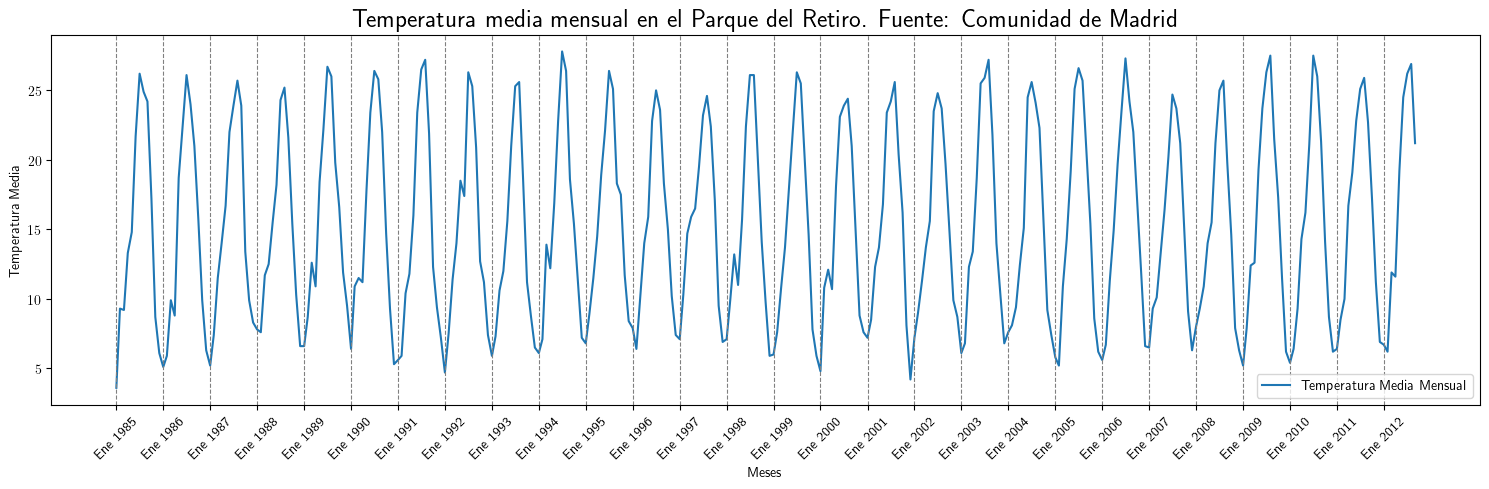

In [7]:
# Generar una columna de fechas desde enero de 1985
df3['Fecha'] = pd.date_range(start='1985-01', periods=len(df3), freq='M') # cambiar por 'ME' en el futuro

# Configurar la columna de fechas como índice
df3.set_index('Fecha', inplace=True)

# Crear el gráfico
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(df3.index, df3['TemperaturaMedia'], label='Temperatura Media Mensual')
ax.set_title('Temperatura media mensual en el Parque del Retiro. Fuente: Comunidad de Madrid', fontsize=18)
ax.set_xlabel('Meses')
ax.set_ylabel('Temperatura Media')
ax.legend()

# Agregar barras verticales en enero de cada año
for fecha in df3.index:
    if fecha.month == 1:  # Mes de enero
        ax.axvline(x=fecha, color='gray', linestyle='--', linewidth=0.8)

# Agregar etiquetas en todos los eneros
ticks = []
labels = []
for fecha in df3.index:
    if fecha.month == 1:  # Enero
        ticks.append(fecha)
        labels.append(f'Ene {fecha.year}')  # Formato: "Ene Año" (ej. "Ene 1985")

ax.set_xticks(ticks)  # Configurar las posiciones de las etiquetas
ax.set_xticklabels(labels, rotation=45)  # Configurar las etiquetas correspondientes

# Asegurar que todas las líneas y etiquetas se muestren
plt.tight_layout()
# Guardar el gráfico
plt.savefig('./img/lecc03/TemperaturaRetiro.png', dpi=300, bbox_inches='tight')

![img](./img/lecc03/TemperaturaRetiro.png)



##### Rendimiento porcentual diario del IBEX 35 (std)



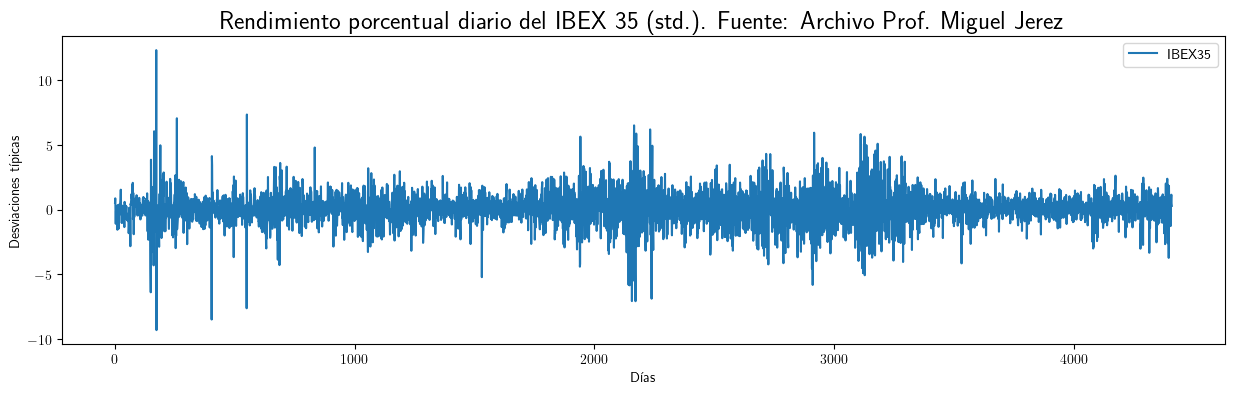

In [8]:
df4.plot(x='obs',xlabel='Días',ylabel='Desviaciones típicas',figsize=(15,4)).set_title('Rendimiento porcentual diario del IBEX 35 (std.). Fuente: Archivo Prof. Miguel Jerez',fontsize=18)
plt.savefig('./img/lecc03/IBEX35.png', dpi=300, bbox_inches='tight')

![img](./img/lecc03/IBEX35.png)



##### Producción de cemento



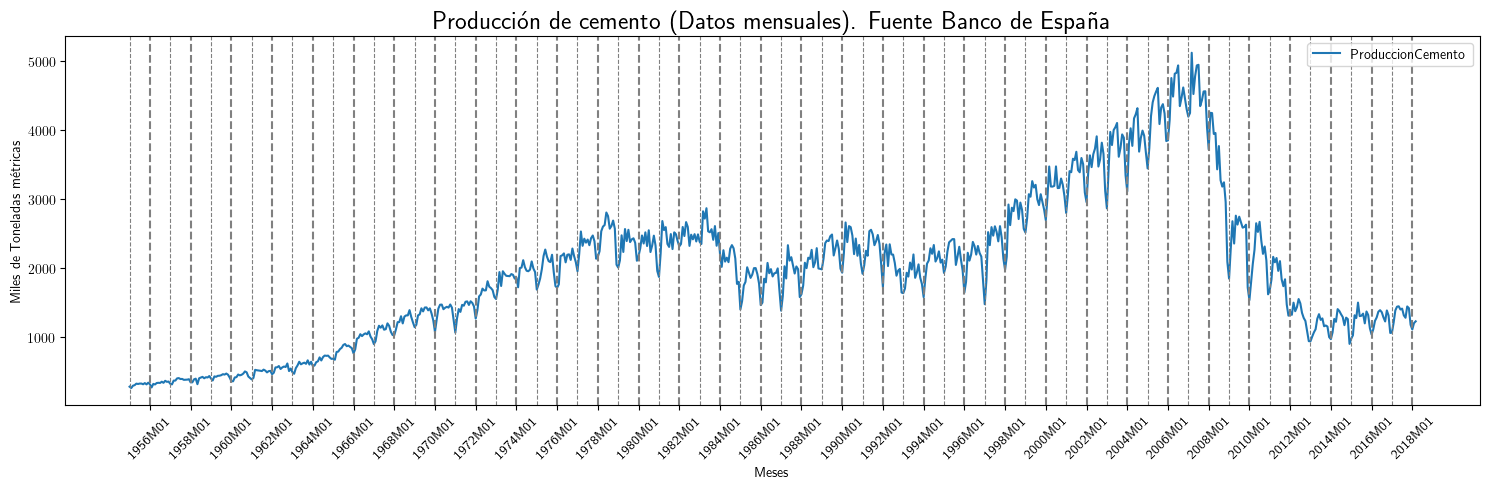

In [9]:
fig, ax = plt.subplots(figsize=(15, 5))
df5.plot(x='obs', xlabel='Meses', ylabel='Miles de Toneladas métricas', ax=ax)
ax.set_title('Producción de cemento (Datos mensuales). Fuente Banco de España', fontsize=18)

# Agregar líneas verticales con diferente grosor para años pares e impares
for i, obs in enumerate(df5['obs']):
    if obs.endswith('M01'):  # Enero
        year = int(obs.split('M')[0])  # Extraer el año
        if year % 2 == 0:  # Años pares
            ax.axvline(x=i, color='gray', linestyle='--', linewidth=1.5)  # Más gruesa
        else:  # Años impares
            ax.axvline(x=i, color='gray', linestyle='--', linewidth=0.8)  # Más fina

# Personalizar las etiquetas del eje X para eneros de años pares
ticks = []
labels = []
for i, obs in enumerate(df5['obs']):
    if obs.endswith('M01'):  # Enero
        year = int(obs.split('M')[0])  # Extraer el año
        if year % 2 == 0:  # Solo años pares
            ticks.append(i)  # Usar el índice como posición
            labels.append(obs)  # Etiqueta completa (ej. "1986M01")

ax.set_xticks(ticks)  # Configurar las posiciones de las etiquetas
ax.set_xticklabels(labels, rotation=45)  # Configurar las etiquetas correspondientes

# Asegurar que todas las líneas y etiquetas se muestren
plt.tight_layout()
plt.savefig('./img/lecc03/ProduccionCemento.png', dpi=300, bbox_inches='tight')

![img](./img/lecc03/ProduccionCemento.png)



Las anteriores series temporales presentan características que impiden su consideración como realizaciones de procesos estocásticos estacionarios. 

-   En tres de ellas &mdash;la población en Australia, el PIB de la zona euro y la producción de cemento&mdash; se observa una tendencia clara, lo que implica una evolución de la media local a medio y largo plazo.
-   Además, se identifican patrones estacionales en las temperaturas medias del Parque del Retiro y en la producción de cemento. Estos patrones son el resultado de la **traslación constante de la Tierra** alrededor del Sol. Tales oscilaciones periódicas generan ciclos regulares, de manera que, por ejemplo, las temperaturas invernales son sistemáticamente más bajas que las estivales.
-   En la producción de cemento, se observa que la amplitud de la variación estacional tiende a aumentar conforme se incrementa el nivel de la serie.
-   Respecto a los rendimientos del IBEX35, se aprecian períodos de alta volatilidad intercalados con fases menos volátiles, lo que indica la presencia de heterocedasticidad.

Todas estas características resaltan la complejidad de los procesos subyacentes y la necesidad de emplear modelos que capten adecuadamente estas propiedades dinámicas.



### Correlación serial vs muestreo aleatorio simple



*Generalmente* cuando disponemos de datos de

-   **sección cruzada:** asumimos que proceden de un el muestreo es aleatorio simple
    -   i.e., los datos son realizaciones de variables aleatorias i.i.d.

-   **series temporales:** dicha asunción resulta errónea
    
    -   con frecuencia el nivel esperado (o la volatilidad) parece cambiar con $t$
    -   con frecuencia hay dependencia temporal (correlación serial).
    
    **Ejemplo**: no parece aceptable asumir que $ProdCemento_{1960M01}$ se distribuye igual que $ProdCemento_{2000M04}$ (ni que sea independiente de $ProdCemento_{1959M01}$).

Veamos por qué esto genera dificultades en su tratamiento estadístico&hellip;



Consideremos el proceso estocástico
$$
 \boldsymbol{X}=(X_t \mid t=0,\pm1,\pm2,\ldots).
$$
Caracterizar su distribución conjunta (**sus infinitos momentos**) resulta ser demasiado ambicioso. Limitemos a los dos primeros momentos (esperanzas y covarianzas):

$$
 E(X_t)=\mu_{\color{Blue}{t}}
 \quad\text{ y }\quad
 Cov(X_t,X_k)=E\big[(X_t-\mu_t)(X_k-\mu_k)\big]=\gamma_{{\color{Blue}{t}},{\color{OliveGreen}{k}}};\quad t,k\in\mathbb{Z}
$$

(donde si $\;k=t\;$, entonces $\;\gamma_{\color{Blue}{{t,t}}}=Var(X_t)=\sigma^2_{\color{Blue}{t}}$).



Si el proceso $\boldsymbol{X}$ fuera gaussiano, estos parámetros bastarían para caracterizar la distribución conjunta completamente. No obstante&hellip;

-   Necesitaríamos una muestra suficiente de cada $X_t$ para estimar los parámetros;
    
    A cada $X_t$ le corresponden infinitos parámetros ($\mu_{t}$, $\;\sigma^2_{t}$, $\;\gamma_{t,{\color{OliveGreen}{k}}};\;\text{ donde } k\in\mathbb{Z}$);
    
    Pero en una serie temporal $\boldsymbol{x}$ solo disponemos de *una* realización para cada $X_t$.



### Simplificación del escenario



Cuando $\boldsymbol{X}$ es [débilmente estacionario](./Lecc01.slides.html#/3/1) se reduce *drásticamente* el número de parámetros (aunque siga habiendo infinitos):

\begin{eqnarray}
  E(X_t)  = &  \mu \\
  Cov(X_t,X_{t-k}) =  & \gamma_k\quad k\in\mathbb{Z}
\end{eqnarray}



El desafío para el analista es (y nótese el abuso de lenguaje)

-   **primero:** transformar los datos para lograr que sean "***débilmente estacionarios***".
    -   (Algo vimos en la lección 1)
-   **después:** transformar los datos estacionarios en "***ruido blanco***"
    -   (Es lo que veremos en esta lección y las siguientes)

Este proceso constituye la especificación y ajuste de un modelo ARIMA a los datos.



Antes de atacar los temas de especificación y ajuste de modelos, debemos estudiar las propiedades de la familia de procesos estocásticos débilmente estacionarios.



## Procesos estocásticos de segundo orden



El ambiente natural para estudiar las propiedades de segundo orden de
una colección de variables aleatorias es el espacio de variables
aleatorias $X$ definidas en un espacio de probabilidad tales que
$$E(X)=0 \quad\text{y}\quad E(X^2)<\infty$$ donde $E$ es el operador
esperanza. Denotaremos este espacio con $H$.



### Un poco de geometría



El espacio, dotado de producto escalar y norma $$\langle X \mid Y
\rangle=E(XY),\qquad \lVert X \rVert= \sqrt{E(X^2)},\qquad X,Y \in
H,$$ es un espacio de Hilbert.

Nótese que como las variables de $H$ tienen esperanza cero, el
producto escalar entre $X,Y\in H$ también es $$\langle X \mid Y
\rangle=Cov(X,Y).$$ Por tanto, en este espacio $H$ la noción
geométrica de ortogonalidad coincide con la noción estadística de *no
correlación*. Por tanto, en este contexto los términos producto
escalar, covarianza y esperanza del producto serán intercambiables
(esto deja de ser cierto cuando hay variables aleatorias con esperanza
no nula).

Una colección de variables aleatorias pertenecientes a $H$
$$\boldsymbol{X}=(X_t\mid t\in\mathbb{Z}) \;\text{ con }\; X_t\in H$$
se denomina *proceso estocástico de segundo orden*.

Si $\boldsymbol{Y}=(Y_t\mid t\in\mathbb{Z})$ es tal que
$E(Y_t)=\mu\ne0$, entonces $\boldsymbol{Y}$ no es de segundo orden.

Pero basta restar $\mu$ de cada $Y_t$ para tener un proceso
$(\boldsymbol{Y}-\mu\boldsymbol{1})$ de segundo orden.

*Por ello siempre asumiremos* (sin pérdida de generalidad) *que las
variables aleatorias de los procesos estocásticos de esta lección* (y
la siguiente) *tienen esperanza cero*.



### Primeros momentos de procesos estocásticos de segundo orden



Si $E(X_t)<\infty$ para $t\in\mathbb{Z}$, entonces $E(\boldsymbol{X})$ es
la secuencia $$E(\boldsymbol{X})=\big(E(X_t)\mid
t\in\mathbb{Z}\big)=\sum\nolimits_{t\in\mathbb{Z}} E(X_t)
z^t=\big(\ldots,\;E(X_{-1}),\;E(X_{0}),\;E(X_{1}),\ldots\big)$$

Si $\boldsymbol{X}$ tiene segundos momentos finitos, la secuencia de
autocovarianzas <u>de orden $k$</u> es

\begin{align*}
%Cov(\boldsymbol{X},\boldsymbol{X}*z^k) = &
%E\Big(\big[\boldsymbol{X}-E(\boldsymbol{X})\big]\odot\big[(\boldsymbol{X}-E(\boldsymbol{X}))*z^k\big]\Big)\\
\left.\Big(Cov(X_t,X_{t-k})\right| t\in\mathbb{Z}\Big)
= & 
%\left.\Big(E\big[\big(X_t-E(X_t)\big)\big(X_{t-k}-E(X_{t-k})\big)\big]\; \right| t\in\mathbb{Z}\Big)\\
%=&
% \sum_{t\in\mathbb{Z}} \gamma_{_{k,t}} z^t
(\gamma_{_{k,t}}\mid t\in\mathbb{Z})\\ % \;=\;
= &
(\ldots,\,\gamma_{_{k,-1}},\,{\color{blue}{\gamma_{_{k,0}}}},\,\gamma_{_{k,1}},\,\gamma_{_{k,2}},\ldots).
\end{align*}

(la secuencia solo contiene la covarianza de un orden $k$ fijo&hellip; pero en distintos instantes $t$).

Así, para cada par $(k,t)$, tenemos la covarianza $\gamma_{k,t}$ entre
$X_t$ y $X_{t-k}$. Por tanto, en general, tenemos una esperanza para
cada $t$ y una covarianza de orden $k$ para cada $t$. Dado que $t$
recorre todos los números enteros (son muchos momentos). <u>Por
eso necesitamos reducir el número de parámetros restringiéndonos a
procesos estocásticos débilmente estacionarios</u>.



### Procesos estocásticos (débilmente) estacionarios y la ACF



Un proceso estocástico de segundo orden $\boldsymbol{X}$ se dice que es *débilmente estacionario* si:

-   $E(X_t)=\mu$ para todo $t$ y
-   la covarianza entre $X_s$ y $X_t$ solo depende de la diferencia $s-t$.

En tal caso, llamamos <u>función de autocovarianzas</u> a la siguiente secuencia:
$$
 \boldsymbol{\gamma} 
 \; = \; 
 (\gamma_{k}\mid k\in\mathbb{Z}) 
 \; = \;
 (\ldots,\,\gamma_{-1},\,{\color{blue}{\gamma_{0}}},\,\gamma_{1},\,\gamma_{2},\ldots)
 \;=\;
 \sum_{-\infty}^{\infty} \gamma_k z^k.
$$

**Propiedades** de la función de autocovarianzas $\boldsymbol{\gamma}$ (ACF):

-   $\gamma_0\geq0$
-   la secuencia $\boldsymbol{\gamma}$ *es definida positiva*; y por tanto,
    -   $\boldsymbol{\gamma}$ es simétrica: $\gamma_k=\gamma_{-k}$
    -   $\boldsymbol{\gamma}$ es acotada: $|\gamma_k|\leq\gamma_0$

Y llamamos <u>función de autocorrelación</u> (ACF) a la secuencia:
$\;\boldsymbol{\rho}=\frac{1}{\gamma_0}(\boldsymbol{\gamma})
=\sum\limits_{k\in\mathbb{Z}}\frac{\gamma_k}{\gamma_0}z^k$.



## Notación: convolución y el operador retardo



SI $\boldsymbol{a}$ es una secuencia de números y $\boldsymbol{X}$ un proceso estocástico tales que, para todo $t$, 
$$
 \text{la suma }\quad  \sum\limits_{k=-\infty}^{\infty}a_kX_{t-k}\quad \text{ converge};
$$
definimos el producto convolución ($*$) de $\boldsymbol{a}$ con $\boldsymbol{X}$ como el proceso estocástico:
$$
 \boldsymbol{a}*\boldsymbol{X}=\left(\left.\sum_{k+s=t} a_k X_s \right| t\in\mathbb{Z}\right)
$$
es decir
$$
 (\boldsymbol{a}*\boldsymbol{X})_t=\sum_{k+s=t} a_k X_s,\quad \text{para } t\in\mathbb{Z}.
$$
Por tanto, cada elemento de 
$
 (\boldsymbol{a}*\boldsymbol{X})
$
es una combinación de variables aleatorias de $\boldsymbol{X}$.



Si aplicamos el operador $\mathsf{B}$ sobre un elemento de $\boldsymbol{X}$ obtenemos el anterior:
$$
 \mathsf{B} X_t = X_{t−1},\quad \text{para } t\in\mathbb{Z}.
$$
Por tanto, aplicando el operador retardo $\mathsf{B}$ repetidamente tenemos
$$
\mathsf{B}^k X_t = X_{t−k},\quad \text{para } t,z\in\mathbb{Z}.
$$



Así, para el polinomio $\boldsymbol{a}(z)=a_0+a_1z+a_2z^2+a_3z^3$, y el proceso estocástico $\boldsymbol{Y}$:

\begin{align*}
\boldsymbol{a}(\mathsf{B})Y_t 
& = (a_0+a_1\mathsf{B}+a_2\mathsf{B}^2+a_3\mathsf{B}^3) Y_t \\
% & = a_0 Y_t + a_1 \mathsf{B}^1 Y_t + a_2 \mathsf{B}^2 Y_t + a_3 \mathsf{B}^3 Y_t \\
& = a_0Y_t+a_1Y_{t-1}+a_2Y_{t-2}+a_3Y_{t-3} \\
% \quad = \quad \sum\nolimits_{k=0}^{3}a_kY_{t-k} \\
% & =\sum\nolimits_{r=0}^3 a_r Y_{t-r} \\
& =(\boldsymbol{a}*\boldsymbol{Y})_t,\quad \text{para } t\in\mathbb{Z}
\end{align*}



Y en general, si la suma $\sum\nolimits_{k=-\infty}^{\infty}a_kY_{t-k}$
converge para todo $t$, entonces

\begin{align*}
\boldsymbol{a}(\mathsf{B})Y_t 
& = (\cdots+a_{-2}\mathsf{B}^{-2}+a_{-1}\mathsf{B}^{-1}+a_0+a_1\mathsf{B}+a_2\mathsf{B}^2+\cdots) Y_t \\
% & = a_0 Y_t + a_1 \mathsf{B}^1 Y_t + a_2 \mathsf{B}^2 Y_t + a_3 \mathsf{B}^3 Y_t \\
& = \cdots+a_{-1}Y_{t+1}+a_0Y_t+a_1Y_{t-1}+a_2Y_{t-2}+\cdots \; = \; \sum\limits_{k=-\infty}^{\infty}a_kY_{t-k} \\
% & =\sum\nolimits_{r=0}^3 a_r Y_{t-r} \\
& =(\boldsymbol{a}*\boldsymbol{Y})_t,\quad \text{para } t\in\mathbb{Z}
\end{align*}



## Ejemplos de procesos (débilmente) estacionarios



### Proceso de ruido blanco



Una secuencia $\boldsymbol{U}=(U_t\mid t\in\mathbb{Z})$ de variables
aleatorias **incorreladas** y tales que $$E(U_t)=0\quad\text{ y }\quad
Var(U_t)=E(U_t^2)=\sigma^2$$ para $\;t\in\mathbb{Z}\;$ y
$\;0<\sigma^2<\infty\;$ se llama *proceso de ruido blanco*.
$\quad\boldsymbol{U}\sim WN(0,\sigma^2)$.



Al ser variables aleatorias incorreladas, su función de
autocovarianzas es $$\boldsymbol{\gamma}(z)\;=\;\sigma^2
z^0\;=\;(\ldots,0,0,\sigma^2,0,0,\ldots)$$

-   Es el proceso estacionario (no trivial) más sencillo.
-   Este proceso es el pilar sobre el que definiremos el resto de
    ejemplos.



### Procesos lineales



Sea $\boldsymbol{U}\sim WN(0,\sigma^2)$ y $\boldsymbol{b}\in
\ell^2$; una secuencia de <u>cuadrado sumable</u>
$\;\sum\limits_{j\in\mathbb{Z}}{b}_j^2<\infty$.

Denominamos *proceso lineal* al proceso estocástico
$\boldsymbol{X}=\boldsymbol{b}*\boldsymbol{U}$ cuyos elementos son $$X_t
\;=\;(\boldsymbol{b}*\boldsymbol{U})_t
\;=\;\boldsymbol{b}(B)U_t \;=\;\sum_{j=-\infty}^\infty {b}_j
U_{t-j},\quad\text{con } t\in\mathbb{Z}.$$

Este proceso es estacionario (véase la demo en los apuntes en <a href="https://mbujosab.github.io/Econometria-Aplicada/Lecciones-pdf/Lecc03.pdf#subsection.4.1">pdf</a>)



$\boldsymbol{b}(B)$ se denomina *función de transferencia* del
filtro lineal que relaciona $X_t$ con $U_t$.



El proceso lineal es *\`\`causal''* si además $\boldsymbol{b}$ es una
<u>serie formal</u> (i.e., $cogrado(\boldsymbol{b})\geq{\color{blue}{0}}$)
$$X_t=\sum_{j=0}^\infty {b}_j U_{t-j};\qquad t\in\mathbb{Z}$$ 
(pues cada $X_t$ es una suma de variables "*del presente y/o el pasado*").



La clase de **procesos lineales causales** incluye muchas e importantes
subclases de procesos, algunas de las cuales son objeto principal de
estudio de este curso.



#### Media móvil infinita. MA($\infty$)



Sea $\;\boldsymbol{U}\sim WN(0,\sigma^2)\;$ y sea
$\;\boldsymbol{\psi}\in \ell^2\;$ una serie formal con <u>infinitos
términos NO nulos</u>; entonces el proceso estocástico
$\boldsymbol{\psi}*\boldsymbol{U}$, cuyos elementos son $$X_t
\;=\;(\boldsymbol{\psi}*\boldsymbol{U})_t
\;=\;\boldsymbol{\psi}(B)U_t \;=\;\sum_{j=0}^\infty \psi_j
U_{t-j};\qquad t\in\mathbb{Z}$$ se denomina proceso de *media móvil
infinita* MA($\infty$).



Algunas clases de procesos lineales causales poseen una representación parsimoniosa, pues basta un número finito de parámetros para describirlos completamente. 
Por ejemplo, cuando $\boldsymbol{\psi}$ tiene un número finito de términos no nulos&hellip;



#### Proceso de media móvil de orden $q$. MA($q$)



Sea $\;\boldsymbol{U}\sim WN(0,\sigma^2)\;$ y sea
$\;\boldsymbol{\theta}\;$ un <u>polinomio de grado $(q)$</u> con
${\color{#008000}{\theta_{0}=1}}$; entonces el proceso estocástico
$\;\boldsymbol{\theta}*\boldsymbol{U},\;$ cuyos elementos son 
$$
 X_t
 \;=\;
 (\boldsymbol{\theta}*\boldsymbol{U})_t
 \;=\;
 \boldsymbol{\theta}(B)U_t 
 \;=\;
 \sum_{j=0}^q\theta_j U_{t-j};
 \qquad t\in\mathbb{Z}
$$
se denomina proceso de *media móvil* MA($q$).



Es decir, si $\;\boldsymbol{\theta} \;=\; 1-\theta_1z-\cdots-\theta_qz^q,\;$ tenemos que
$$
 X_t = U_t - \theta_1 U_{t-1} - \cdots - \theta_q U_{t-q}.
$$



Hay otros procesos lineales con representación parsimoniosa.



#### Proceso autorregresivo de orden $p$. AR($p$)



Sea $\;\boldsymbol{U}\sim WN(0,\sigma^2)\;$, se denomina *proceso autorregresivo de orden $p$* a aquel proceso estocástico *estacionario* $\;\boldsymbol{X}\;$ que es solución de la siguiente ecuación
$$
 \boldsymbol{\phi}*\boldsymbol{X}=\boldsymbol{U}
$$
donde $\;\boldsymbol{\phi}\;$ un <u>polinomio de grado $(p)$</u> con ${\color{#008000}{\phi_{0}=1}}$.



Por tanto, 
$$
 (\boldsymbol{\phi}*\boldsymbol{X})_t
 \;=\;
 \boldsymbol{\phi}(\mathsf{B})X_t
 \;=\;
 \sum_{j=0}^p \phi_j X_{t-j}
 \;=\;
 U_t.
$$



Si $\;\boldsymbol{\phi}=1-\phi_1z-\cdots-\phi_pz^p,\;$ entonces $\boldsymbol{X}=(X_t\mid t\in\mathbb{Z})$ es solución de la ecuación en diferencias:
$$
 X_t - \phi_1 X_{t-1} - \cdots -\phi_q X_{t-q} = U_t.
$$



El problema con la anterior definición es que la ecuación $\boldsymbol{\phi}*\boldsymbol{X}=\boldsymbol{U}$ no tiene solución única (y en algunos casos ninguna solución es estacionaria).
Despejemos $\boldsymbol{X}$ para verlo.

Multiplicando ambos lados de la ecuación por una inversa de $\boldsymbol{\phi}$ tenemos
$$
 \boldsymbol{X}=inversa(\boldsymbol{\phi})*\boldsymbol{U}.
$$
Y si denotamos la secuencia $inversa(\boldsymbol{\phi})$ con $\boldsymbol{a}$ entonces
$$
 X_t=\boldsymbol{a}(\mathsf{B})U_t=\sum_{j\in\mathbb{Z}} a_j U_{t-j}.
$$



Pero&hellip; ¿qué secuencia $\boldsymbol{a}$ usamos como inversa de $\boldsymbol{\phi}$?
Recuerde que hay infinitas y la mayoría no son sumables
(si el polinomio $\boldsymbol{\phi}$ tiene raíces unitarias ninguna lo es).

<div class="org-center">
<p>
En tal caso la expresión
$\;\boldsymbol{a}(\mathsf{B})U_t=\sum\limits_{j=-\infty}^\infty a_j U_{t-j}\;$ 
carece de sentido (pues la suma no converge).
</p>
</div>



**Requisitos** sobre el polinomio autorregresivo $\boldsymbol{\phi}:\;$ para que el proceso AR exista y sea

1.  <u>lineal y estacionario</u>, exigiremos que $\boldsymbol{\phi}$ <u>no tenga raíces de módulo 1</u>.
    
    Entonces existe una única inversa absolutamente sumable: $\boldsymbol{\phi}^{-1} \in    \ell^1\subset\ell^2$.
    
    La inversa $\boldsymbol{\phi}^{-1}$ corresponde a la única solución *estacionaria* de $\boldsymbol{\phi}*\boldsymbol{X}=\boldsymbol{U}$.
    (Si $\boldsymbol{\phi}$ tuviera raíces de módulo 1 no existiría ni $\boldsymbol{\phi}^{-1}\in\ell^1$, ni solución estacionaria).
    
    $$X_t=\boldsymbol{\phi}^{-1}(\mathsf{B})U_t=\sum_{j=-\infty}^\infty a_j U_{t-j}$$

2.  <u>causal</u>, exigiremos que las raíces de $\boldsymbol{\phi}$ sean mayores que 1 en valor absoluto (<u>raíces fuera del círculo unidad</u>):
    $\boldsymbol{\phi}^{-1}=\boldsymbol{\phi}^{-\triangleright}\;$ (**serie formal** $\in\ell^1\subset\ell^2$).
    
    $$X_t=\boldsymbol{\phi}^{-1}(\mathsf{B})U_t=\sum_{j=0}^\infty a_j U_{t-j};\quad\text{donde } \boldsymbol{a}=\boldsymbol{\phi}^{-1}.$$



(¡de nuevo un proceso lineal causal!)



El siguiente modelo lineal es una generalización de los dos anteriores.



#### Proceso autorregresivo de media móvil. ARMA($p,q$)



Sea $\;\boldsymbol{U}\sim WN(0,\sigma^2)\;$, se denomina *proceso autorregresivo de media móvil $(p,q)$* al proceso estocástico estacionario $\;\boldsymbol{X}\;$ que es solución de la ecuación en diferencias:
$$
 \boldsymbol{\phi}*\boldsymbol{X}=\boldsymbol{\theta}*\boldsymbol{U}
$$
donde el polinomio *autorregresivo* $\;\boldsymbol{\phi}\;$ tiene grado $p$ con ${\color{#008000}{\phi_{0}=1}}$ y con todas sus raíces fuera del círculo unidad (*por los motivos anteriormente vistos*);
y el polinomio *de media móvil* $\;\boldsymbol{\theta}\;$ es de grado $q$ con ${\color{#008000}{\theta_{0}=1}}$; 

$$
 \text{es decir,}\qquad
 \boldsymbol{X}=\frac{\boldsymbol{\theta}}{\boldsymbol{\phi}}*\boldsymbol{U};
 \qquad\text{donde }\;
 \frac{\boldsymbol{\theta}}{\boldsymbol{\phi}}\equiv\boldsymbol{\phi}^{-1}*\boldsymbol{\theta}
$$



Tanto $\boldsymbol{\phi}^{-1}$ como $\boldsymbol{\theta}$ son series formales absolutamente sumables. Dado que tanto $\ell^1$ como las series formales son anillos: $\;\boldsymbol{\phi}^{-1} * \boldsymbol{\theta}$ es otra una serie formal absolutamente sumable (y, por lo tanto, de cuadrado sumable). Consecuentemente, $\boldsymbol{X}$ es, nuevamente, un proceso estocástico **lineal causal**.
$$
 X_t
 \;=\;
 \frac{\boldsymbol{\theta}}{\boldsymbol{\phi}}(\mathsf{B})U_t
 \;=\;
 \sum_{j=0}^\infty a_j U_{t-j};
 \quad\text{donde } \boldsymbol{a}=\frac{\boldsymbol{\theta}}{\boldsymbol{\phi}}.
$$



#### Proceso autorregresivo de media móvil con media no nula



Consideremos un proceso $\boldsymbol{Y}$ con media
distinta de cero, es decir, $$E(Y_t)=\mu\ne0$$ y definamos la
secuencia constante $\boldsymbol{\mu}=\sum\limits_{j\in\mathbb{Z}} \mu
z^j=(\ldots,\mu,\mu,\mu,\ldots)$. 
\medskip

Decimos que $\boldsymbol{Y}$ es un proceso ARMA($p,q$) con media
distinta de cero si $\boldsymbol{X}$ es ARMA($p,q$)
$$\boldsymbol{\phi}*\boldsymbol{X}=\boldsymbol{\theta}*\boldsymbol{U}$$
donde $\boldsymbol{X}=\boldsymbol{Y}-\boldsymbol{\mu}$ es
evidentemente un proceso de media cero.  Por tanto

\begin{align*}
\boldsymbol{\phi}*(\boldsymbol{Y}-\boldsymbol{\mu})=&\boldsymbol{\theta}*\boldsymbol{U}\\
\boldsymbol{\phi}*\boldsymbol{Y}-\boldsymbol{\phi}*\boldsymbol{\mu}=&\boldsymbol{\theta}*\boldsymbol{U}\\
\boldsymbol{\phi}*\boldsymbol{Y}=&\boldsymbol{\phi}*\boldsymbol{\mu}+ \boldsymbol{\theta}*\boldsymbol{U}\\
\end{align*}

Es decir, si $\boldsymbol{\phi}(\mathsf{B})$ es
$\;1-\phi_1\mathsf{B}-\phi_2\mathsf{B}^2-\cdots-\phi_p\mathsf{B}^p,\;$
entonces $$\boldsymbol{\phi}(B){Y_t}=c+\boldsymbol{\theta}(B){U_t}$$
donde $$\;c=(1-\phi_1-\phi_2-\cdots-\phi_p)\mu\;$$ y donde
$\;\mu=E(Y_t)$, es un proceso autorregresivo de media móvil
ARMA($p,q$) *con media no nula*.



## Primeros momentos de procesos lineales causales



### Esperanza y autocovarianzas de un proceso lineal causal



Sea $\;\boldsymbol{X}=\boldsymbol{\psi}*\boldsymbol{U},\;$ donde $\boldsymbol{\psi}$ es una serie formal de cuadrado sumable y donde $\;\boldsymbol{U}\sim WN(0,\sigma^2).\quad$ 
Recordando que la convolución es una operación lineal: 
$$
 E(\boldsymbol{X}) =E(\boldsymbol{\psi}*\boldsymbol{U})
 =\boldsymbol{\psi}*E(\boldsymbol{U})
 =\boldsymbol{\psi}*\boldsymbol{0}=\boldsymbol{0}.
$$
Así, la covarianza de orden $k$ para cada $X_t$ es 
(demo en el [pdf](https://mbujosab.github.io/Econometria-Aplicada/Lecciones-pdf/Lecc03.pdf#subsection.4.2)):
$$
 \gamma_{_{k,t}}
 \;=\;
 E\Big[\big(\boldsymbol{\psi}(\mathsf{B})X_t\big)\cdot \big(\boldsymbol{\psi}(\mathsf{B}) X_{t-k}\big)\Big] 
 % \;=\;
 % \sigma^2\sum\nolimits_{j\in\mathbb{Z}}\psi_{j+k}\psi_j
 \;=\;
 \sigma^2 \big(\boldsymbol{\psi}(z)*\boldsymbol{\psi}(z^{-1})\big)_k
$$
que no depende de $t$ ($\boldsymbol{X}$ es estacionario), es decir, $\gamma_{_{k,t}}=\gamma_{k}$.
Y, por tanto

\begin{equation}
 \label{eqAutoCovarianzaProcesoLineal}
 \boldsymbol{\gamma}=\sigma^2\boldsymbol{\psi}(z)*\boldsymbol{\psi}(z^{-1}).
\end{equation}

con grado igual al grado de $\boldsymbol{\theta}$ y cogrado igual a menos
el grado de $\boldsymbol{\theta}$.



### Covarianza cruzada entre dos procesos lineales causales



Sean $\;\boldsymbol{W}=\boldsymbol{\theta}*\boldsymbol{U}\quad$ e
$\quad\boldsymbol{Y}=\boldsymbol{\psi}*\boldsymbol{U},\quad$ donde
$\boldsymbol{\theta}$ y $\boldsymbol{\psi}$ son series formales de
cuadrado sumable y donde $\;\boldsymbol{U}\sim
WN(0,\sigma^2)$.

Repitiendo los mismos pasos que en el caso de la autocovarianza,
llegamos a que la <u>función de covarianzas cruzadas</u> es la secuencia

\begin{equation}
 \label{eqCovarianzaCruzadaProcesosLineales}
 \boldsymbol{\gamma_{_{\boldsymbol{W},\boldsymbol{Y}}}} =
 \sigma^2 \boldsymbol{\theta}(z)*\boldsymbol{\psi}(z^{-1})
\end{equation}

con grado igual al grado de $\boldsymbol{\theta}$ y cogrado igual a menos
el grado de $\boldsymbol{\psi}$.



Un proceso de ruido blanco $\boldsymbol{U}\sim WN(0,\sigma^2)$ es un
proceso *débilmente estacionario* (o estacionario de segundo orden)
tal que: $$E(U_t)=0;\qquad t\in\mathbb{Z}$$ y $$\boldsymbol{\gamma} =
(\ldots,\,0,\,0,\,{\color{blue}{\sigma^2}},\,0,\,0,\ldots)=\sigma^2
z^0;$$ es decir, $\;\gamma_0=\sigma^2\;$ y $\;\gamma_k=0\;$ para todo
$k\ne0$.

Consideremos el proceso estocástico: $\quad\boldsymbol{X}=(X_t \mid
t=0,\pm1,\pm2,\ldots).\quad$ Lo podemos denotar con una función
generatriz (como hicimos con las secuencias) $$\boldsymbol{X} \quad =
\quad \sum_{t=-\infty}^\infty X_t z^t \quad\equiv\quad
\boldsymbol{X}(z)$$ Recuerde que esto no es una suma; es una secuencia
de variables aleatorias $$\sum_{t=-\infty}^\infty X_t z^t = (\ldots,\
X_{-2},\ X_{-1},\ X_{0},\ X_{1},\ X_{2},\ldots)$$

